## 1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer

## 2. Load Official Train and Test Sets


In [2]:
train_df = pd.read_csv('NSL_KDD_Train.csv')
test_df = pd.read_csv('NSL_KDD_Test.csv')

print('Train Shape:', train_df.shape)
print('Test Shape:', test_df.shape)


Train Shape: (125973, 43)
Test Shape: (22544, 43)


## 3. Data Exploration


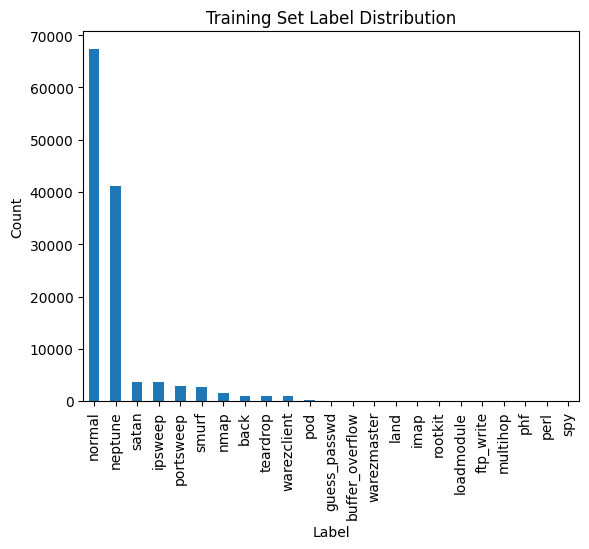

In [3]:
train_counts = train_df['label'].value_counts()
plt.figure()
train_counts.plot(kind='bar')
plt.title('Training Set Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


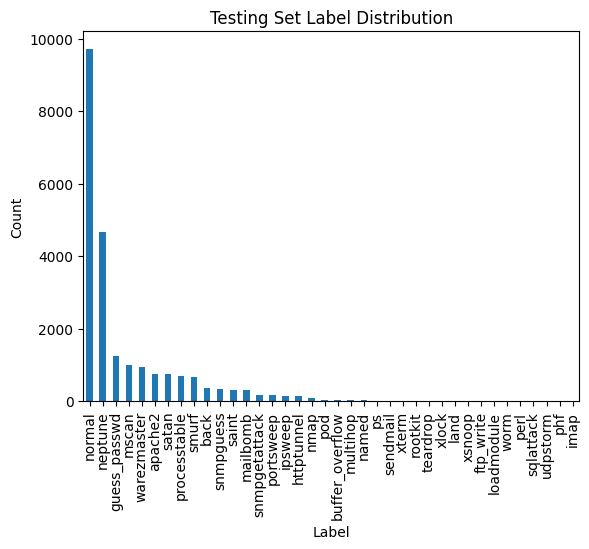

In [4]:
test_counts = test_df['label'].value_counts()
plt.figure()
test_counts.plot(kind='bar')
plt.title('Testing Set Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


## 4. Convert to Binary Classification


In [5]:
train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']


## 5. Encoding Categorical Variables and Feature Scaling (Mean Imputation)

In [6]:
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Define numerical_transformer and preprocessor to include an imputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Mean Imputation
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),  #Encoding
        ('num', numerical_transformer, numerical_cols)  #Mean Imputation -> Z-Score Feature Scaling
    ]
)


## 7. Model Training and Evaluation


In [7]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=42)
}

accuracies = {}
roc_data = {}


for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("=========================================================================\n")



Logistic Regression Accuracy: 0.8100
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      9711
           1       0.92      0.73      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.82      0.82      0.81     22544
weighted avg       0.83      0.81      0.81     22544



KNN Accuracy: 0.8324
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      9711
           1       0.97      0.73      0.83     12833

    accuracy                           0.83     22544
   macro avg       0.85      0.85      0.83     22544
weighted avg       0.87      0.83      0.83     22544



Random Forest Accuracy: 0.7886
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81 

## 8. Model Accuracy Comparison


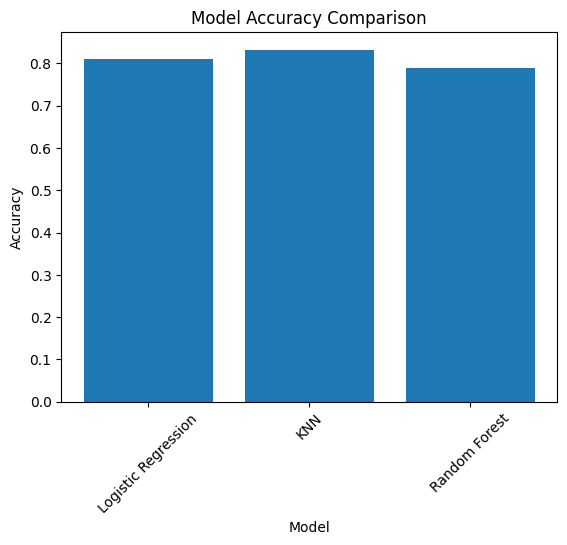

In [8]:
plt.figure()
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


## 9. ROC Curve Comparison


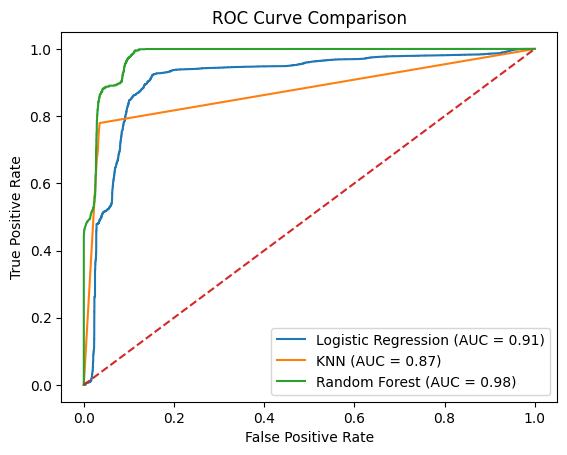

In [9]:
plt.figure()
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


## 10. Statistical Feature Importance

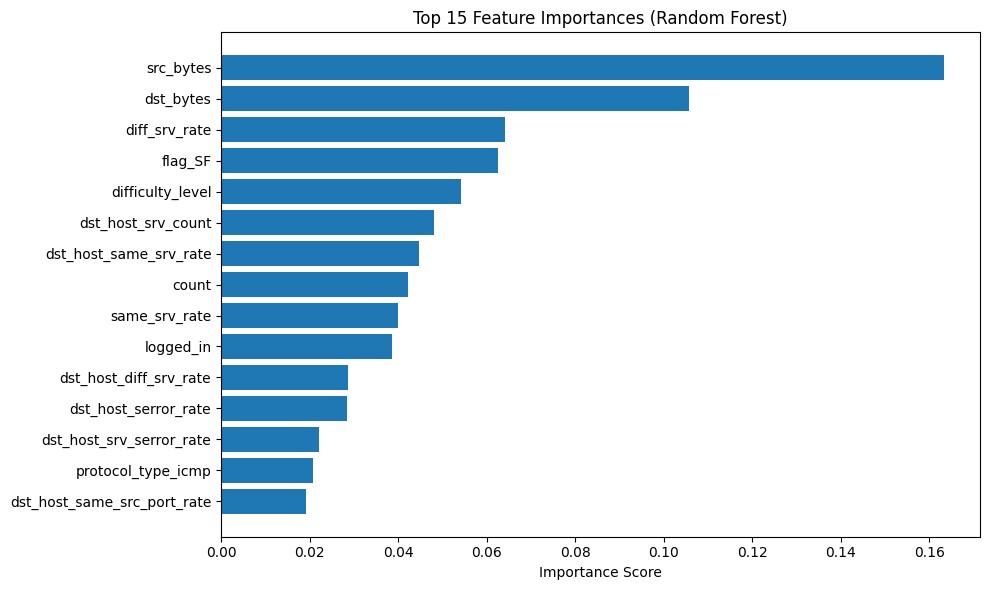

In [10]:
# Extract trained Random Forest model
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight='balanced',
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = rf_pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)

all_feature_names = np.concatenate([encoded_cat_features, numerical_cols])

# Get feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Top 15 Important Features
plt.figure(figsize=(10,6))
plt.barh(
    feature_importance_df['Feature'][:15][::-1],
    feature_importance_df['Importance'][:15][::-1]
)
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()